In [19]:
import json
import numpy as np
import seaborn as sns
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

In [20]:
def get_dataset_json(dataset_path:Path):
    json_path = dataset_path.joinpath('dataset.json')
    with open(json_path, 'r') as f:
        dataset_json = json.load(f)
    return dataset_json

def print_basic_stats(dataset_json):
    print(f"Dataset name: {dataset_json['name']}")
    print(f"Dataset description: {dataset_json.get('description', 'unknown')}")
    print(f"Imaging modality: {dataset_json['modality']}")
    print(f"Dataset labels: {dataset_json['labels']}")
    print(f"Num training samples: {dataset_json['numTraining']}")
    print(f"Num testing samples: {dataset_json.get('numTest', 'unknown')}")

In [21]:
# Path to datasets
task_01_path = Path("/mnt/d/Task01_BrainTumour")
task_03_path = Path("/mnt/d/Task03_Liver")
task_07_path = Path("/mnt/d/Task07_Pancreas")

task_01 = get_dataset_json(task_01_path)
task_03 = get_dataset_json(task_03_path)
task_07 = get_dataset_json(task_07_path)

In [22]:
print_basic_stats(task_01)
print('*' * 50)
print_basic_stats(task_03)
print('*' * 50)
print_basic_stats(task_07)
print('*' * 50)

Dataset name: BRATS
Dataset description: Gliomas segmentation tumour and oedema in on brain images
Imaging modality: {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Dataset labels: {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Num training samples: 484
Num testing samples: 266
**************************************************
Dataset name: Liver
Dataset description: Liver, and cancer segmentation
Imaging modality: {'0': 'CT'}
Dataset labels: {'0': 'background', '1': 'liver', '2': 'cancer'}
Num training samples: 131
Num testing samples: 70
**************************************************
Dataset name: Pancreas
Dataset description: Pancreas and cancer segmentation
Imaging modality: {'0': 'CT'}
Dataset labels: {'0': 'background', '1': 'pancreas', '2': 'cancer'}
Num training samples: 281
Num testing samples: 139
**************************************************


In [23]:
def get_image_properties(dataset_path, max_images = 10):
    train_dir = dataset_path.joinpath('imagesTr')
    labels_dir = dataset_path.joinpath('labelsTr')

    files = list(train_dir.glob('[!.]*.nii.gz'))[:max_images]

    dataset_statistics = {
        'names':[],
        'image_dimensions':[],
        'voxel_spacings':[],
        'intensity_stats':[],
        'non_zero_voxels':[],
        'total_voxels':[],
        'voxels_per_label':[],
    }

    for f_path in tqdm(files):
        try:
            image = sitk.ReadImage(str(f_path))
            image_array = sitk.GetArrayFromImage(image)
            
            label_file = labels_dir.joinpath(f_path.name)
            if label_file.exists():
                label = sitk.ReadImage(str(label_file))
                label_array = sitk.GetArrayFromImage(label)
            else:
                label_array = None
                print(f'No label array found for {f_path.name}')

            dataset_statistics['names'].append(f_path.stem)
            dataset_statistics['image_dimensions'].append(image_array.shape)
            dataset_statistics['voxel_spacings'].append(image.GetSpacing())
            dataset_statistics['intensity_stats'].append((
                float(image_array.min()),
                float(image_array.max()),
                float(image_array.mean()),
                float(image_array.std()),
                float(np.median(image_array))
            ))
            dataset_statistics['non_zero_voxels'].append(int(np.count_nonzero(image_array)))
            dataset_statistics['total_voxels'].append(int(image_array.size))
            
            if label_array is not None:
                unique_labels = np.unique(label_array)
                dataset_statistics['voxels_per_label'].append({
                    int(label): int(np.sum(label_array == label)) 
                    for label in unique_labels
                })

        except Exception as e:
            print(f"Error processing {f_path}: {e}") 

    return dataset_statistics
    


In [24]:
def plot_spacing(dataset, dataset_stats):
    spacings = dataset_stats['voxel_spacings']
    if len(spacings[0]) == 4:
        spacing_df = pd.DataFrame(spacings, columns=['c', 'x', 'y', 'z'])
        axes = ['c', 'x', 'y', 'z']
    else:
        spacing_df = pd.DataFrame(spacings, columns=['x', 'y', 'z'])
        axes = ['x', 'y', 'z']

    fig, axs = plt.subplots(1, len(axes), figsize = (4 * len(axes), 4))

    
    for i, axis in enumerate(axes):
        axs[i].hist(spacing_df[axis], bins = 20)
        axs[i].set_title(f'{axis.upper()}-axis Spacing')
        axs[i].set_xlabel('Spacing (mm)')
        axs[i].set_ylabel('Frequency')

    plt.suptitle(f'{dataset} Voxel Spacing Distribution')
    plt.tight_layout()
    plt.show()

def plot_dimension(dataset, dataset_stats):
    dims = dataset_stats['image_dimensions']

    if len(dims[0]) == 4:
        dim_df = pd.DataFrame(dims, columns=['channels', 'depth', 'height', 'width'])
        axes = ['channels', 'depth', 'height', 'width']
    else:
        dim_df = pd.DataFrame(dims, columns=['depth', 'height', 'width'])
        axes = ['depth', 'height', 'width']

    fig, axs = plt.subplots(1, len(axes), figsize = (4 * len(axes), 4))

    for i, axis in enumerate(axes):
        axs[i].hist(dim_df[axis], bins = 20)
        axs[i].set_title(f'{axis.title()} Dimensions')
        axs[i].set_xlabel('Voxels')
        axs[i].set_ylabel('Frequency')

    plt.suptitle(f'{dataset} Voxel Spacing Distribution')
    plt.tight_layout()
    plt.show()

def plot_intensity_stats(dataset, dataset_stats):
    stats = dataset_stats['intensity_stats']
    
    stats_df = pd.DataFrame(stats, columns=['min', 'max', 'mean', 'std', 'median'])

    fig, axs = plt.subplots(1, 5, figsize = (12, 4))

    for i, axis in enumerate(['min', 'max', 'mean', 'std', 'median']):
        axs[i].hist(stats_df[axis], bins = 20)
        axs[i].set_title(f'Intensity {axis.title()}')
        axs[i].set_xlabel('Intensity')
        axs[i].set_ylabel('Frequency')

    plt.suptitle(f'{dataset} Intensity Statistics Distribution')
    plt.tight_layout()
    plt.show()

def plot_target_stats(dataset, dataset_stats):
    stats = dataset_stats['voxels_per_label']
    names = dataset_stats['names']

    all_classes = set()
    for class_count in stats:
        all_classes.update(class_count.keys())
    
    all_classes = sorted(list(all_classes))

    proportions = []
    for class_count in stats:
        total_voxels = sum(class_count.values())
        sample_props = [class_count.get(class_name, 0)/total_voxels for class_name in all_classes]
        proportions.append(sample_props)

    proportions = np.array(proportions).T

    fig, ax = plt.subplots(figsize=(10, 5))
    
    bottom = np.zeros(len(stats))
    colors = plt.cm.Set1(np.linspace(0, 1, len(all_classes)))
    
    bars = []
    for i, (class_name, color) in enumerate(zip(all_classes, colors)):
        bar = ax.bar(names, proportions[i], bottom=bottom, 
                    label=class_name, color=color, alpha=0.8)
        bars.append(bar)
        bottom += proportions[i]
    
    # Customize the plot
    ax.set_ylabel('Proportion of Voxels', fontsize=12)
    ax.set_xlabel('Sample ID', fontsize=12)
    ax.set_title('title', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)

    # Tight layout to prevent label cutoff
    plt.tight_layout()
    plt.show()


def collect_and_plot_stats(dataset, dataset_path):
    task_stats = get_image_properties(dataset_path, max_images=None)
    plot_spacing(dataset['name'], task_stats)
    plot_dimension(dataset['name'], task_stats)
    plot_intensity_stats(dataset['name'], task_stats)
    plot_target_stats(dataset['name'], task_stats)
    return task_stats

In [25]:
stats = get_image_properties(task_01_path, max_images=10)

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


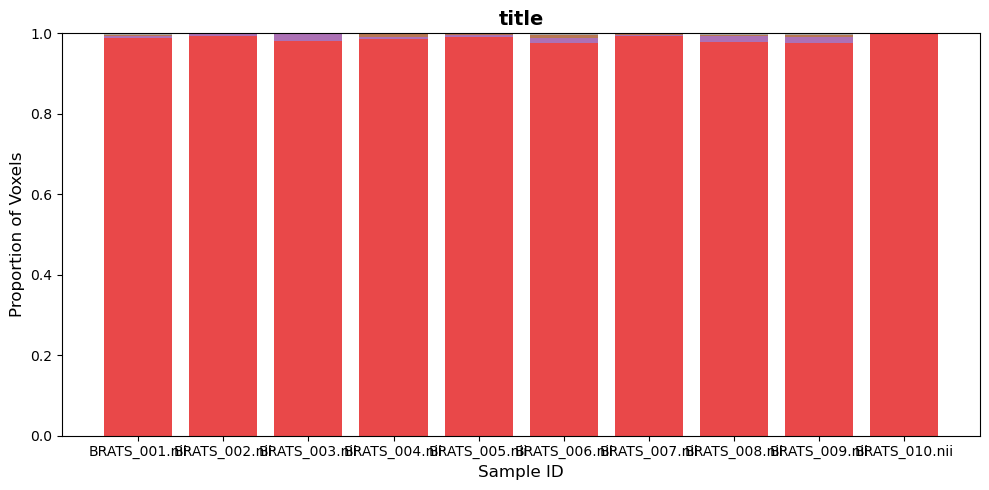

In [26]:
plot_target_stats('test', stats)

In [27]:
stats = collect_and_plot_stats(task_01, task_01_path)

  1%|          | 3/484 [00:03<08:46,  1.09s/it]


KeyboardInterrupt: 

100%|██████████| 131/131 [13:11<00:00,  6.04s/it]


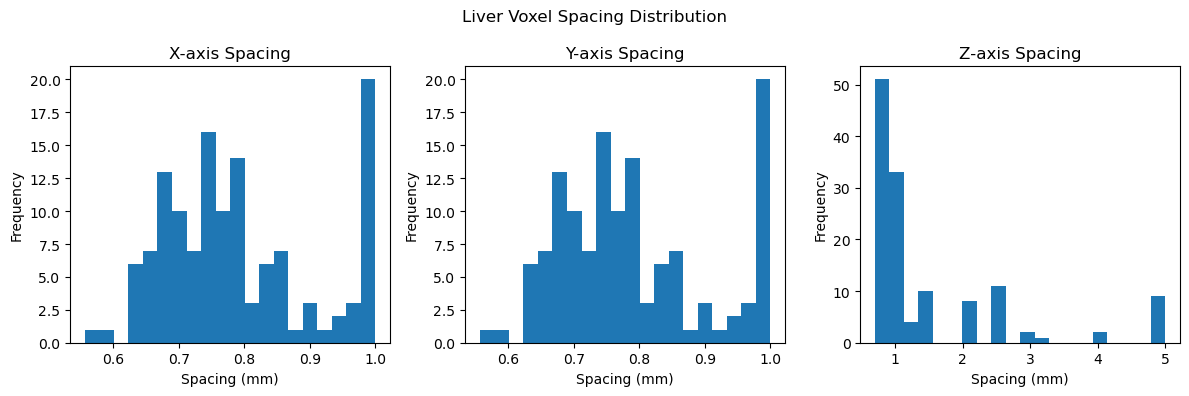

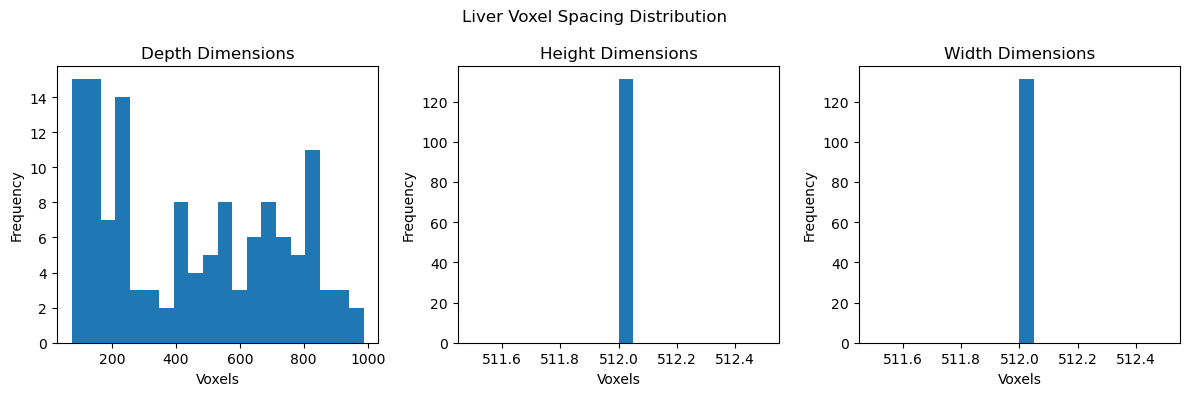

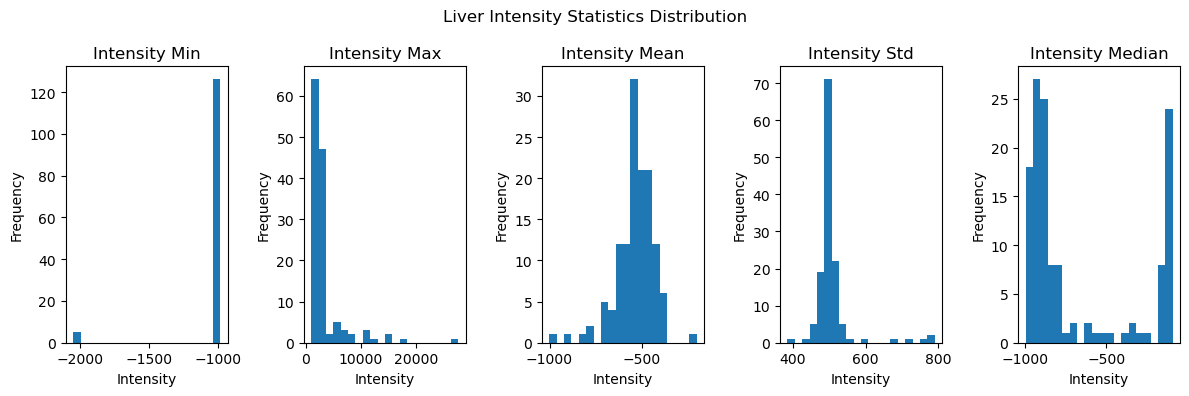

In [ ]:
collect_and_plot_stats(task_03, task_03_path)

100%|██████████| 281/281 [05:56<00:00,  1.27s/it]


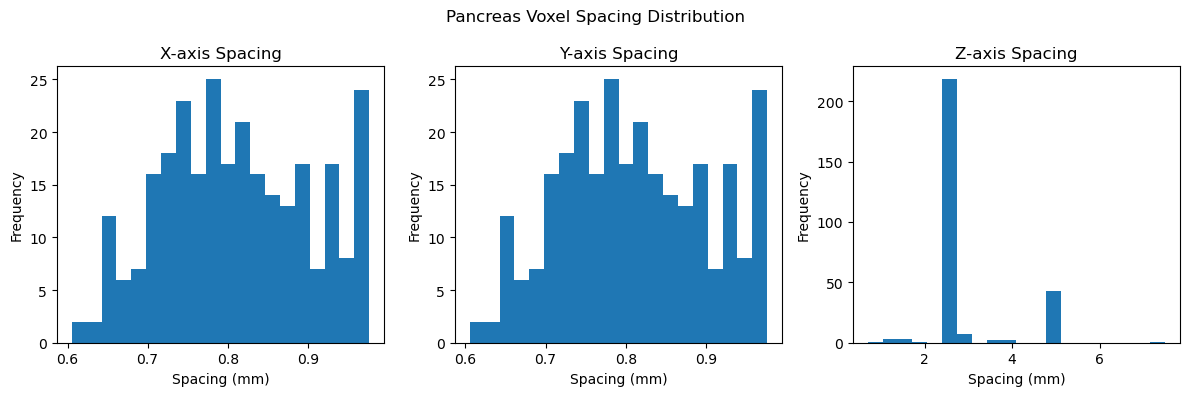

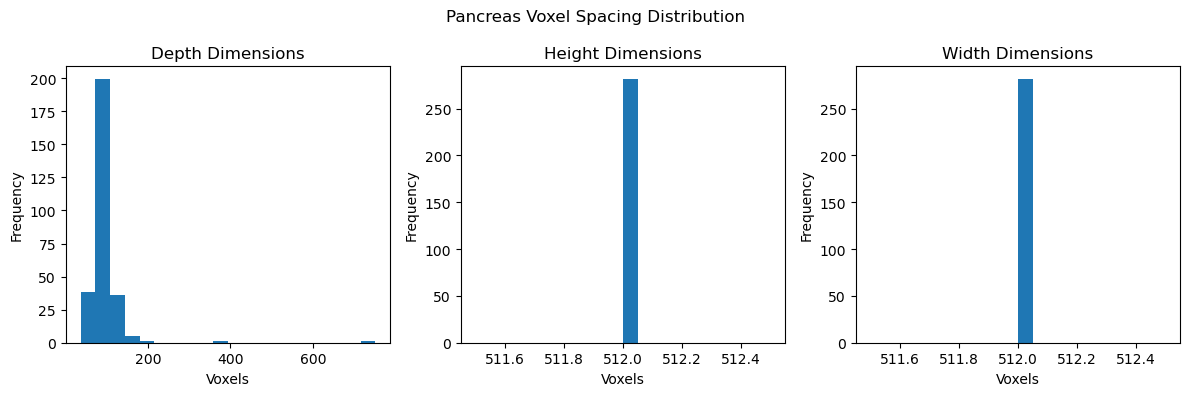

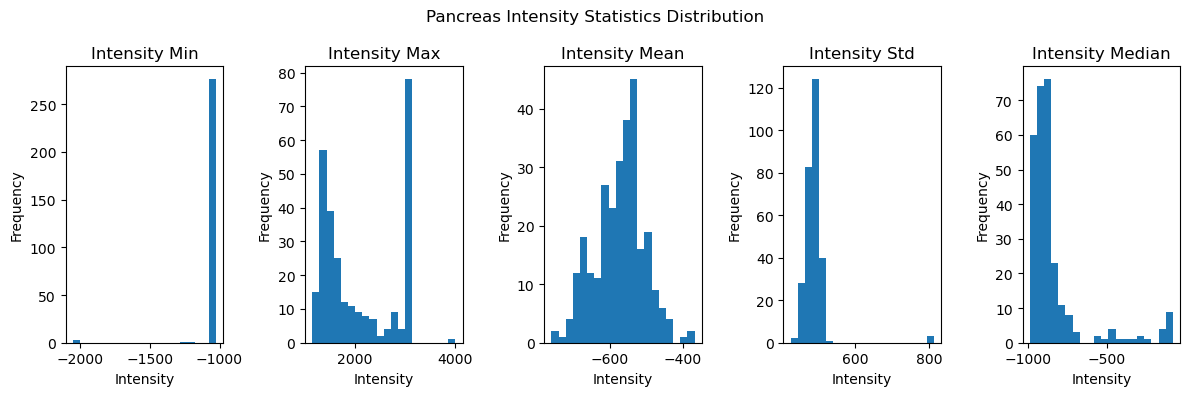

In [ ]:
collect_and_plot_stats(task_07, task_07_path)